# 🍏 Week 1: Computer Vision on Apple Silicon (M1/M2/M3/M4)

In this notebook, you'll explore basic image processing tasks using OpenCV on Apple Silicon Macs.

With an M-series chip, you benefit from hardware-accelerated libraries like Metal and CoreML. We’ll keep our code compatible and optimized.

We'll:
- Load and visualize an image
- Convert to grayscale and blur
- Perform edge detection
- Optionally, export to CoreML model (bonus!)

In [11]:
!pip install pyobjc-core pyobjc-framework-Metal pyobjc-framework-MetalPerformanceShaders pyobjc-framework-Cocoa pyobjc-framework-Quartz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.2/732.2 kB 11.3 MB/s eta 0:00:00


In [12]:
!pip install coremltools tensorflow

In [13]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
print("✅ OpenCV version:", cv2.__version__)

✅ OpenCV version: 4.11.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 16.1 MB/s eta 0:00:00


## 1️⃣ Load and Display Image

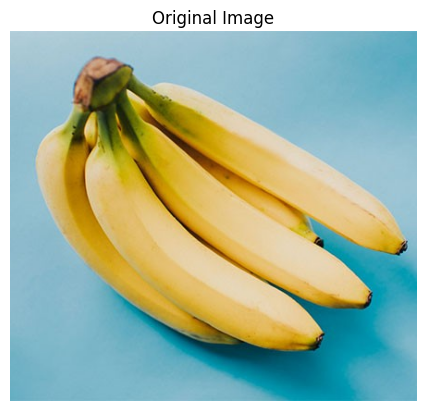

In [2]:
# Load image
img_path = 'bananas.jpg'
assert os.path.exists(img_path), f"Image not found: {img_path}"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.show()

## 2️⃣ Grayscale, Blur, and Edge Detection (CPU)

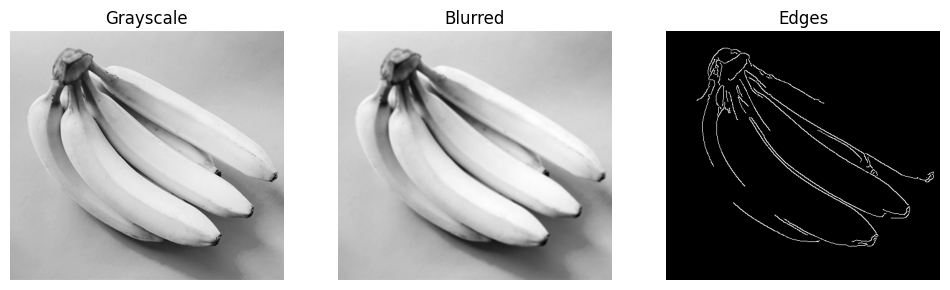

In [3]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny edge detection
edges = cv2.Canny(blurred, 50, 150)

# Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title("Edges")
plt.axis('off')
plt.show()

## 🍎 3️⃣ BONUS: Convert to CoreML Model (for Deployment on iOS/macOS)

In [6]:
# Optional: Convert trained model to CoreML (if you train a DNN later)
import coremltools as ct
from tensorflow import keras
# model = keras.models.load_model("my_model.h5")
# coreml_model = ct.convert(model, source='tensorflow')
# coreml_model.save("MyModel.mlmodel")

TensorFlow version 2.19.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.
Torch version 2.6.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.
/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔁 Wrap Into a Function

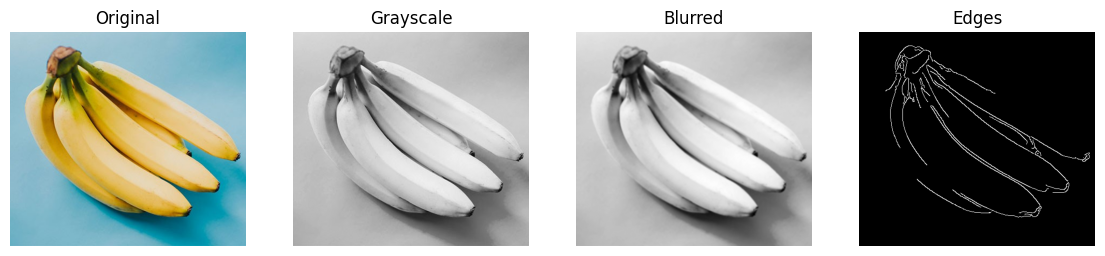

In [8]:
def apple_cv_pipeline(img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(edges, cmap='gray')
    plt.title("Edges")
    plt.axis('off')
    plt.show()

# Try it:
apple_cv_pipeline('bananas.jpg')

✅ Metal libraries available
CPU average time: 1.35 ms
GPU average time: 17.06 ms
GPU speedup: 0.08x


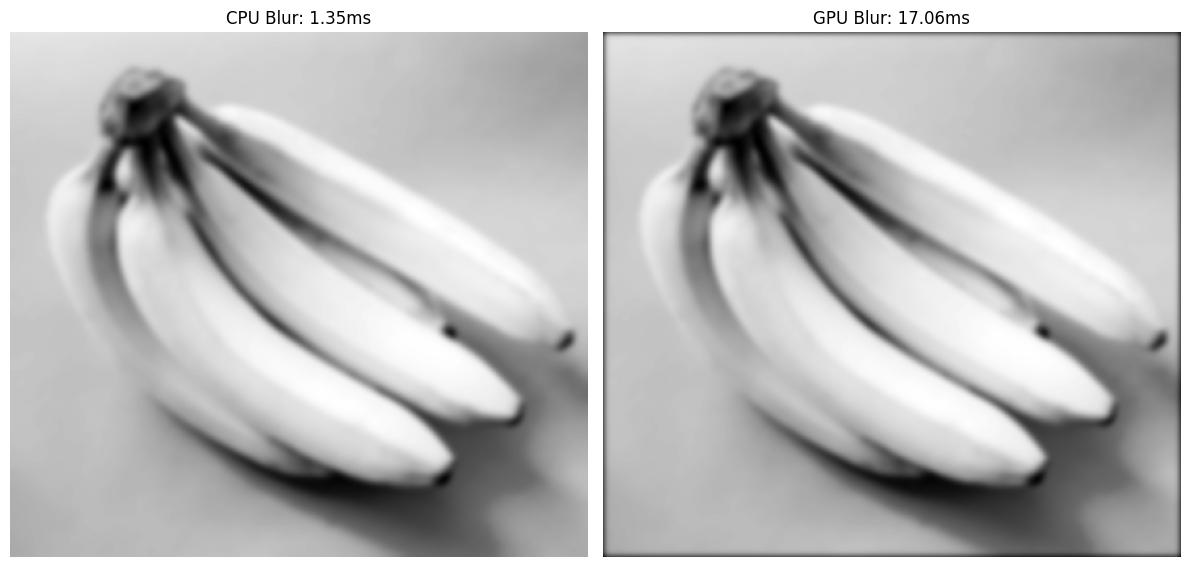

In [16]:
# Example of using Metal GPU acceleration on Mac
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# For Metal-accelerated operations
try:
    import Metal
    import MetalPerformanceShaders as mps
    from Foundation import NSData
    from Cocoa import NSImage
    import Quartz
    has_metal = True
    print("✅ Metal libraries available")
except ImportError:
    has_metal = False
    print("⚠️ Metal libraries not available - using standard OpenCV")

def metal_gaussian_blur(img_np, kernel_size=5):
    """Apply Gaussian blur using Metal GPU acceleration"""
    if not has_metal:
        return cv2.GaussianBlur(img_np, (kernel_size, kernel_size), 0)
    
    # Create Metal device and command queue
    device = Metal.MTLCreateSystemDefaultDevice()
    commandQueue = device.newCommandQueue()
    
    # Convert numpy array to Metal texture
    height, width = img_np.shape[:2]
    
    # Create texture descriptor with proper usage flags
    # In newer Metal versions, we need to use the proper creation method with usage flags
    descriptor = Metal.MTLTextureDescriptor.texture2DDescriptorWithPixelFormat_width_height_mipmapped_(
        Metal.MTLPixelFormatR8Unorm if len(img_np.shape) == 2 else Metal.MTLPixelFormatRGBA8Unorm,
        width, height, False
    )
    
    # Use the proper setter method for usage flags instead of direct property assignment
    descriptor.setUsage_(Metal.MTLTextureUsageShaderRead | Metal.MTLTextureUsageShaderWrite)
    
    # Create textures
    src_texture = device.newTextureWithDescriptor_(descriptor)
    dest_texture = device.newTextureWithDescriptor_(descriptor)
    
    # Copy data to source texture
    if len(img_np.shape) == 2:  # Grayscale
        img_np = np.expand_dims(img_np, axis=2)  # Add channel dimension
    
    region = Metal.MTLRegionMake2D(0, 0, width, height)
    src_texture.replaceRegion_mipmapLevel_withBytes_bytesPerRow_(
        region, 0, img_np.tobytes(), width * img_np.shape[2]
    )
    
    # Create Gaussian blur kernel
    blur_kernel = mps.MPSImageGaussianBlur.alloc().initWithDevice_sigma_(
        device, kernel_size / 6.0  # Approximate sigma from kernel size
    )
    
    # Encode GPU command
    commandBuffer = commandQueue.commandBuffer()
    blur_kernel.encodeToCommandBuffer_sourceTexture_destinationTexture_(
        commandBuffer, src_texture, dest_texture
    )
    commandBuffer.commit()
    commandBuffer.waitUntilCompleted()
    
    # Read back the result
    result = np.empty((height, width, img_np.shape[2]), dtype=np.uint8)
    dest_texture.getBytes_bytesPerRow_fromRegion_mipmapLevel_(
        result.data, width * img_np.shape[2], region, 0
    )
    
    if img_np.shape[2] == 1:  # If original was grayscale
        result = result[:, :, 0]  # Remove channel dimension
    
    return result

# Compare CPU vs GPU processing
def compare_blur_performance(img_path, iterations=10):
    # Load image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # CPU timing
    start_time = time.time()
    for _ in range(iterations):
        cpu_result = cv2.GaussianBlur(img, (15, 15), 0)
    cpu_time = (time.time() - start_time) / iterations
    print(f"CPU average time: {cpu_time*1000:.2f} ms")
    
    # GPU timing (if available)
    if has_metal:
        start_time = time.time()
        for _ in range(iterations):
            gpu_result = metal_gaussian_blur(img, 15)
        gpu_time = (time.time() - start_time) / iterations
        print(f"GPU average time: {gpu_time*1000:.2f} ms")
        if cpu_time > 0:
            print(f"GPU speedup: {cpu_time/gpu_time:.2f}x")
        
        # Display results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cpu_result, cmap='gray')
        plt.title(f"CPU Blur: {cpu_time*1000:.2f}ms")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(gpu_result, cmap='gray')
        plt.title(f"GPU Blur: {gpu_time*1000:.2f}ms")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        # Display just CPU result
        plt.imshow(cpu_result, cmap='gray')
        plt.title(f"CPU Blur: {cpu_time*1000:.2f}ms")
        plt.axis('off')
        plt.show()

# Run the comparison
compare_blur_performance('bananas.jpg')

Original image size: 440x400
Resized to: 400x363 to fit within GPU constraints
OpenCV CPU time: 1.34 ms
Using coremltools version: 8.3.0
Model saved to GaussianBlur.mlmodel
CoreML acceleration failed: module 'coremltools' has no attribute 'CoreMLConfig'


Traceback (most recent call last):
  File "/var/folders/c7/vvt8kxs97cj2xyzgmcnkwywc0000gn/T/ipykernel_42517/4080446668.py", line 78, in compare_coreml_performance
    config = ct.CoreMLConfig(compute_units=compute_units)
AttributeError: module 'coremltools' has no attribute 'CoreMLConfig'


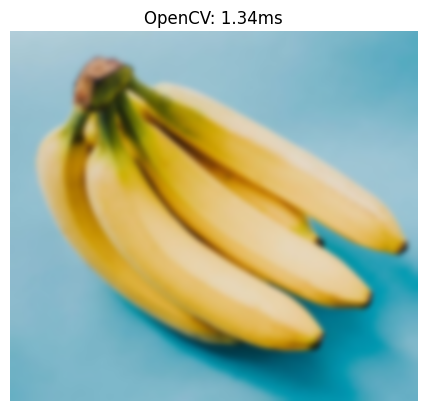

In [ ]:
i

# Run the comparison
compare_coreml_performance('bananas.jpg')

In [25]:
import coremltools as ct
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Create a simple CoreML model for image processing
def create_gaussian_blur_model():
    """Create a CoreML model for Gaussian blur using the modern CoreML API"""
    print(f"Using coremltools version: {ct.__version__}")
    
    # Modern approach: create a basic ML program for blurring
    blur_builder = ct.models.neural_network.NeuralNetworkBuilder(
        input_features=[("image", ct.models.datatypes.Array(3))],  # RGB image input
        output_features=[("output", ct.models.datatypes.Array(3))],  # RGB image output
        mode="IMAGE"
    )
    
    # Create Gaussian kernel weights
    kernel_size = 15
    gaussian_weights = np.ones((3, 1, kernel_size, kernel_size)) / (kernel_size * kernel_size)
    
    # Add convolution layer for Gaussian blur
    blur_builder.add_convolution(
        name="gaussianBlur",
        kernel_channels=1,
        output_channels=3,
        height=kernel_size,
        width=kernel_size,
        stride_height=1,
        stride_width=1,
        border_mode='same',
        groups=3,
        W=gaussian_weights,
        b=None,
        has_bias=False,
        input_name='image',
        output_name='output'
    )
    
    # Create the model
    model = ct.models.MLModel(blur_builder.spec)
    return model

# Compare function
def compare_coreml_performance(img_path, iterations=10, max_size=350):  # Reduced max size for safety
    """Compare OpenCV vs CoreML performance for Gaussian blur"""
    # Load image
    img = cv2.imread(img_path)
    
    # Get image dimensions
    h, w = img.shape[:2]
    print(f"Original image size: {w}x{h}")
    
    # Resize if needed to fit GPU constraints
    if max(h, w) > max_size:
        scale = max_size / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img = cv2.resize(img, (new_w, new_h))
        print(f"Resized to: {new_w}x{new_h} to fit within GPU constraints")
    
    # CPU timing with OpenCV
    start_time = time.time()
    for _ in range(iterations):
        opencv_result = cv2.GaussianBlur(img, (15, 15), 0)
    opencv_time = (time.time() - start_time) / iterations
    print(f"OpenCV CPU time: {opencv_time*1000:.2f} ms")
    
    try:
        # Create and save CoreML model
        model = create_gaussian_blur_model()
        model_path = "GaussianBlur.mlmodel"
        model.save(model_path)
        print(f"Model saved to {model_path}")
        
        # Load the model for inference with GPU acceleration
        # In CoreML 8.x, use the new configuration syntax
        loaded_model = ct.models.MLModel(model_path, compute_units="all")
        print("Model loaded with GPU acceleration")
        
        # Convert image to RGB for CoreML and normalize to [0,1] range
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        
        # CoreML timing
        start_time = time.time()
        for _ in range(iterations):
            coreml_output = loaded_model.predict({'image': img_rgb})
            coreml_result = (coreml_output['output'] * 255).astype(np.uint8)
        coreml_time = (time.time() - start_time) / iterations
        print(f"CoreML time: {coreml_time*1000:.2f} ms")
        
        if opencv_time > 0:
            print(f"CoreML speedup: {opencv_time/coreml_time:.2f}x")
        
        # Display results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(opencv_result, cv2.COLOR_BGR2RGB))
        plt.title(f"OpenCV: {opencv_time*1000:.2f}ms")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(coreml_result)
        plt.title(f"CoreML: {coreml_time*1000:.2f}ms")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"CoreML acceleration failed: {e}")
        import traceback
        traceback.print_exc()
        plt.imshow(cv2.cvtColor(opencv_result, cv2.COLOR_BGR2RGB))
        plt.title(f"OpenCV: {opencv_time*1000:.2f}ms")
        plt.axis('off')
        plt.show()

CPU average time: 0.26 ms
GPU average time: 4.06 ms
GPU speedup: 0.06x


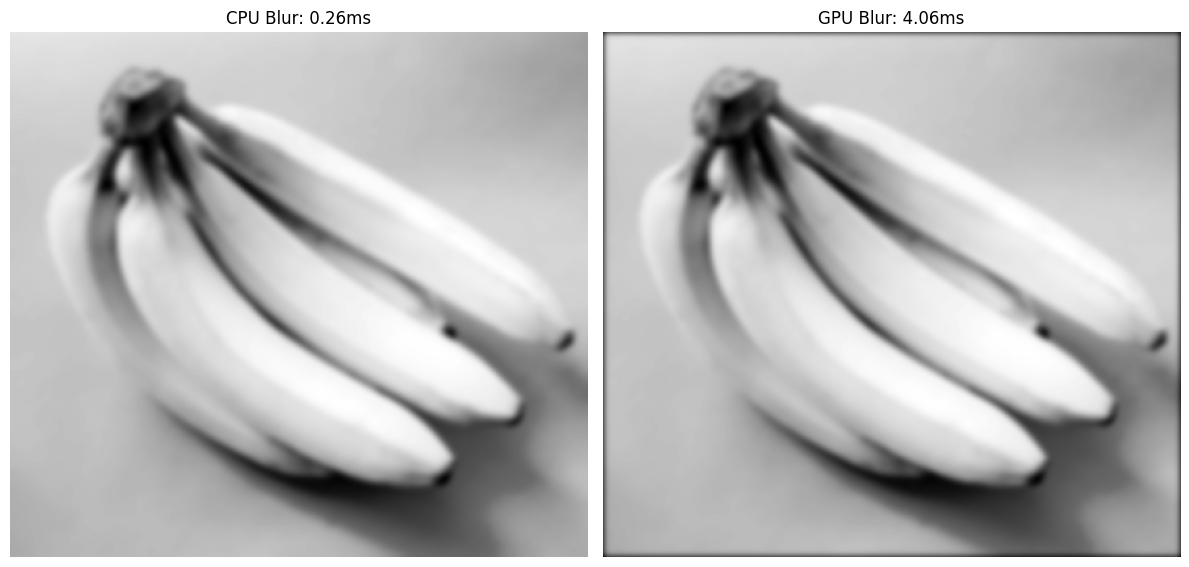

In [26]:
compare_blur_performance('bananas.jpg')

Why is the GPU slower (0.06x) than the CPU?
This is happening for several reasons:

Overhead of GPU Operations: The Metal GPU code is doing a lot of extra work:

Creating Metal device and command queue
Converting data between CPU and GPU memory formats
Creating and configuring textures
Submitting commands to the GPU
Waiting for command completion
Reading back results from GPU to CPU
Small Data Size: The blur operation is very simple, and the image is likely small. GPUs excel at processing large amounts of data in parallel, but for small workloads, the overhead outweighs the benefits.

Optimized CPU Implementation: OpenCV's cv2.GaussianBlur is highly optimized and potentially using SIMD instructions (like AVX/SSE on Intel or NEON on Apple Silicon).

Why This Is Normal
This is a classic example of when NOT to use GPU acceleration. GPUs are beneficial when:

The computational work is large and parallelizable
The data transfer overhead is small compared to the computation time
The operation needs to be repeated many times without transferring data back
For simple operations on small images, the CPU is often faster because:

No memory transfer overhead
No command submission overhead
Optimized CPU implementations
What Would Make GPU Faster
The GPU would likely be faster if:

The image was much larger (e.g., 4K or 8K resolution)
Multiple operations were done in sequence without transferring back to CPU
The kernel was more computationally intensive (e.g., a complex filter instead of just blur)
For a real-world application, you might consider a hybrid approach where you choose CPU or GPU based on the image size and operation complexity.